In [ ]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
import xgboost

import warnings
warnings.filterwarnings("always")

## **Load Data**

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving fichtraining_ROYA_CAMPO_nondup.csv to fichtraining_ROYA_CAMPO_nondup.csv
Saving SupplementaryTable3_RubioTeso_etal_Martonne.xlsx to SupplementaryTable3_RubioTeso_etal_Martonne.xlsx


In [ ]:
roya = pd.read_csv("fichtraining_ROYA_CAMPO_nondup.csv",decimal=',',sep=';',)

roya.head()

,inputs.data.species,DECLONGITUDE,DECLATITUDE,bio_1,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,long,ROYA_CAMPO_AVERAGE_DSR,CODIGO_BANCO,CODIGO_IAS,DECLONGROUND,DECLATROUND
0,1,5.133333,43.916667,110.919998,5194,14868.750000,1451.699951,37.0,23.700001,28.799999,5.145833,0.000000,PI 572342,1595.0,5.13,43.91
1,1,16.950278,43.356944,145.125000,4663,14057.916992,1416.525024,44.0,24.924999,26.799999,16.937500,0.000000,PI 572349,1599.0,16.95,43.35
2,1,33.413333,36.333056,147.679993,7992,18051.416016,1516.525024,43.0,22.775000,15.600000,33.395833,0.000000,PI 572406,1631.0,33.41,36.33
3,1,85.516667,25.183333,263.679993,15245,18996.083984,1539.250000,47.0,21.799999,8.300000,85.520833,0.454545,PI 472137,1524.0,85.51,25.18
4,1,74.350000,32.333333,238.000000,9956,17067.666016,1590.425049,42.0,21.025000,13.800000,74.354167,0.909091,PI 426797,1447.0,74.34,32.33


In [ ]:
fig = px.scatter_geo(roya, lat="DECLATITUDE", lon="DECLONGITUDE", color="ROYA_CAMPO_AVERAGE_DSR")
fig.show()

In [ ]:
df = roya.drop(roya.columns[[0, 12, 13, 14, 15]], axis=1)

## MODELS

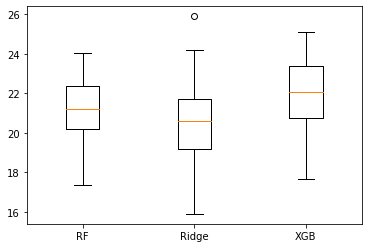

RF RMSE mean 21.200448487213702
XGB RMSE mean 22.015009905718756
Ridge RMSE mean 20.44113196696655


In [ ]:
error_values_rf = []
error_values_xgb = []
error_values_ridge = []

importances_rf = {}
importances_xgb = {}
importances_ridge = {}

for col in list(df):
    if col!= 'ROYA_CAMPO_AVERAGE_DSR':
        importances_rf[col] = []
        importances_xgb[col] = []
        importances_ridge[col] = []

nexper = 100
for i in range(0, nexper):

    variables_to_ignore = ['ROYA_CAMPO_AVERAGE_DSR','DECLONGITUDE','DECLATITUDE']
    selected_features = [element for element in list(df) if element not in variables_to_ignore]
    
    df_model = df[selected_features]
    
    std_scaler = StandardScaler()
    
    std_scaler_model = std_scaler.fit(df_model)
    df_model = std_scaler_model.transform(df_model)
    
    
    "Division Train Test"
    
    X = pd.DataFrame(data = df_model, columns = selected_features)
    y = df.ROYA_CAMPO_AVERAGE_DSR

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)


    "Random Forest"

    rf = RandomForestRegressor(random_state= 123, n_jobs = -1)
    
    rf.fit(X_train,y_train)
    predictions_rf = rf.predict(X_test)

    rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

    for k in range(0, len(selected_features)):
        importances_rf[selected_features[k]].append(rf.feature_importances_[k])
    
    error_values_rf.append(rmse_rf)

    "XGBoost"

    xgb = xgboost.XGBRegressor(verbosity = 0)
    xgb.fit(X_train,y_train)
    
    predictions_xgb = xgb.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

    for k in range(0, len(selected_features)):
        importances_xgb[selected_features[k]].append(xgb.feature_importances_[k])

    error_values_xgb.append(rmse_xgb)

    "Ridge"

    clf = RidgeCV(alphas=np.linspace(0.001, 1, 1000)).fit(X, y)
    clf.fit(X_train, y_train)

    predictions_ridge = clf.predict(X_test)

    rmse_ridge = np.sqrt(mean_squared_error(y_test, predictions_ridge))

    for k in range(0, len(selected_features)):
        importances_ridge[selected_features[k]].append(clf.coef_[k])

    error_values_ridge.append(rmse_ridge)

def to_str(var):
    return str(list(np.reshape(np.asarray(var), (1, np.size(var)))[0]))[1:-1]

arr = [error_values_rf, error_values_ridge, error_values_xgb]
box = plt.boxplot(arr,labels=['RF','Ridge','XGB'])
plt.show()

print("RF RMSE mean",np.mean(error_values_rf))
print("XGB RMSE mean",np.mean(error_values_xgb))
print("Ridge RMSE mean",np.mean(error_values_ridge))

In [ ]:
from google.colab import  drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
pd.DataFrame(error_values_rf).to_excel("/drive/My Drive/Doctorado/Lenteja/results/error_values_rf.xlsx")
pd.DataFrame(error_values_xgb).to_excel("/drive/My Drive/Doctorado/Lenteja/results/error_values_xgb.xlsx") 
pd.DataFrame(error_values_ridge).to_excel("/drive/My Drive/Doctorado/Lenteja/results/error_values_ridge.xlsx") 

## FEATURE IMPORTANCE

In [ ]:
importances_rf_avg = {}
importances_xgb_avg = {}
importances_ridge_avg = {}

for k,v in importances_rf.items():
    if k != 'DECLATITUDE' and k != 'DECLONGITUDE':
        importances_rf_avg[str(k)] = np.mean(v)
for k,v in importances_xgb.items():
    if k != 'DECLATITUDE' and k != 'DECLONGITUDE':
        importances_xgb_avg[str(k)] = np.mean(v)
for k,v in importances_ridge.items():
    if k != 'DECLATITUDE' and k != 'DECLONGITUDE':
        v_abs = [np.abs(val) for val in v]
        importances_ridge_avg[str(k)] = np.mean(v_abs)

In [ ]:
importances_rf_avg

{'bio_1': 0.09654764656933784,
 'long': 0.32743947801525125,
 'srad_12': 0.0735991766468,
 'srad_annual': 0.09096771829187458,
 't_bulk_dens': 0.1296324632298199,
 't_sand': 0.07699606901050708,
 't_soilwater_cap': 0.11920334811395569,
 't_teb': 0.08561410012245368}

In [ ]:
importances_xgb_avg

{'bio_1': 0.076230854,
 'long': 0.3557832,
 'srad_12': 0.087708585,
 'srad_annual': 0.09948148,
 't_bulk_dens': 0.100202255,
 't_sand': 0.0818566,
 't_soilwater_cap': 0.094291665,
 't_teb': 0.10444537}

In [ ]:
importances_ridge_avg

{'bio_1': 1.8691399582980028,
 'long': 7.198910097465881,
 'srad_12': 2.6274165932098525,
 'srad_annual': 4.257025645113488,
 't_bulk_dens': 1.7892303329243326,
 't_sand': 2.7067541240745654,
 't_soilwater_cap': 5.1922882460472,
 't_teb': 1.5076452752618126}

In [ ]:
importances_rf_avg = pd.DataFrame(data=importances_rf_avg, index=[0])
importances_rf_avg = (importances_rf_avg.T)

importances_xgb_avg = pd.DataFrame(data=importances_xgb_avg, index=[0])
importances_xgb_avg = (importances_xgb_avg.T)

importances_ridge_avg = pd.DataFrame(data=importances_rf_avg, index=[0])
importances_ridge_avg = (importances_rf_avg.T)

In [ ]:
pd.DataFrame.from_dict(importances_rf_avg).to_excel("/drive/My Drive/Doctorado/Lenteja/results/importances_rf_avg.xlsx")
pd.DataFrame.from_dict(importances_xgb_avg).to_excel("/drive/My Drive/Doctorado/Lenteja/results/importances_xgb_avg.xlsx") 
pd.DataFrame.from_dict(importances_ridge_avg).to_excel("/drive/My Drive/Doctorado/Lenteja/results/importances_ridge_avg.xlsx") 

## RIDGE REGRESSION

In [ ]:
variables_to_ignore = ['ROYA_CAMPO_AVERAGE_DSR','DECLONGITUDE','DECLATITUDE']
selected_features = [element for element in list(df) if element not in variables_to_ignore]

df_model = df[selected_features]

std_scaler = StandardScaler()

std_scaler_model = std_scaler.fit(df_model)
df_model = std_scaler_model.transform(df_model)


"Division Train Test"

X = pd.DataFrame(data = df_model, columns = selected_features)
y = df.ROYA_CAMPO_AVERAGE_DSR

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7)

clf = RidgeCV(alphas=np.linspace(0.001, 1, 1000)).fit(X, y)
clf.fit(X_train, y_train)

predictions_train = clf.predict(X_train)

predictions_test = clf.predict(X_test)

In [ ]:
X_train['DECLONGITUDE'] =df['DECLONGITUDE']
X_train['DECLATITUDE'] =df['DECLATITUDE']

X_test['DECLONGITUDE'] =df['DECLONGITUDE']
X_test['DECLATITUDE'] =df['DECLATITUDE']

In [ ]:
train_values = X_train.reset_index()
train_values['predictions'] = pd.Series(predictions_train)

test_values = X_train.reset_index()
test_values['predictions'] = pd.Series(predictions_test)


In [ ]:
train_values.to_excel("/drive/My Drive/Doctorado/Lenteja/results/train_values.xlsx")
test_values.to_excel("/drive/My Drive/Doctorado/Lenteja/results/test_values.xlsx")

In [ ]:
fig = px.scatter_geo(train_values, lat="DECLATITUDE", lon="DECLONGITUDE", color="predictions")
fig.show()

In [ ]:
fig = px.scatter_geo(test_values.dropna(), lat="DECLATITUDE", lon="DECLONGITUDE", color="predictions")
fig.show()

## NEW DATASET

In [ ]:
from google.colab import files 
uploaded = files.upload()

In [ ]:
roya_test = pd.read_excel("SupplementaryTable3_RubioTeso_etal_Martonne.xlsx")
roya_test = roya_test[['Latitude_decimal','Longitude_decimal','bio_1','srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap','t_teb', 'long','DeMartonneANNUAL']]
roya_test['DeMartonneANNUAL'] = pd.to_numeric(roya_test['DeMartonneANNUAL'], errors='coerce')
roya_test.head()

,Latitude_decimal,Longitude_decimal,bio_1,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,long,DeMartonneANNUAL
0,38.523891,22.502781,9.944834,0.5364,14913.33301,1422.625000,28.0,23.950001,37.599998,0.856812,40.110638
1,44.650000,33.700000,10.797833,0.5352,13129.16699,1484.375000,21.0,23.825001,22.900000,0.932749,23.848638
2,44.483333,33.716667,9.402000,0.5124,13137.33301,1451.250000,23.0,24.150000,22.100000,0.732039,29.429955
3,41.724720,34.582500,8.059834,0.4556,14525.75000,1402.900024,38.0,23.650000,27.100000,-0.929344,37.431131
4,37.100000,37.200000,14.031000,0.5284,17900.00000,1502.800049,26.0,24.900000,13.400000,-0.113753,24.135492


In [ ]:
roya_test = roya_test.dropna()

roya_test_pred = roya_test.drop(columns=['Latitude_decimal','Longitude_decimal','DeMartonneANNUAL'])
roya_test_pred_scaled = std_scaler_model.transform(roya_test_pred)

predictions_rf = rf.predict(roya_test_pred_scaled)

In [ ]:
predictions_xgb = xgb.predict(pd.DataFrame(roya_test_pred_scaled, columns=['bio_1', 'srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap', 't_teb', 'long']))

In [ ]:
predictions_ridge = clf.predict(roya_test_pred_scaled)

In [ ]:
roya_test['predictions_ridge'] = predictions_ridge

In [ ]:
fig = px.scatter_geo(roya_test, lat="Latitude_decimal", lon="Longitude_decimal", color="DeMartonneANNUAL")
fig.show()

In [ ]:
fig = px.scatter_geo(roya_test, lat="Latitude_decimal", lon="Longitude_decimal", color="predictions_ridge")
fig.show()

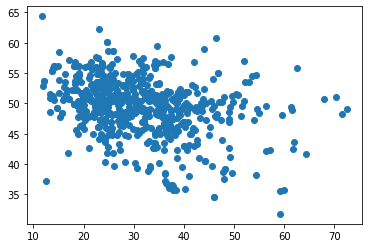

In [ ]:
plt.scatter(roya_test['DeMartonneANNUAL'], roya_test['predictions_ridge'])

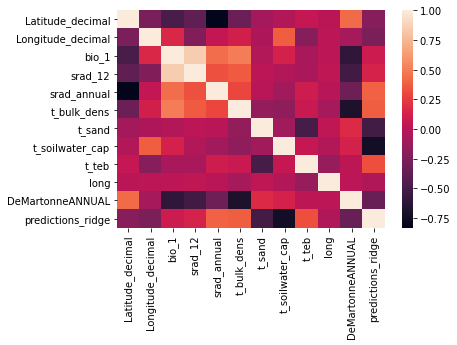

In [ ]:
# calculate the correlation matrix
corr = roya_test.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)